In [168]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

In [176]:
train_df = pd.read_csv('train_mnist.csv')
test_df = pd.read_csv('test_mnist.csv')

# Análisis Exploratorio de Datos

<BarContainer object of 10 artists>

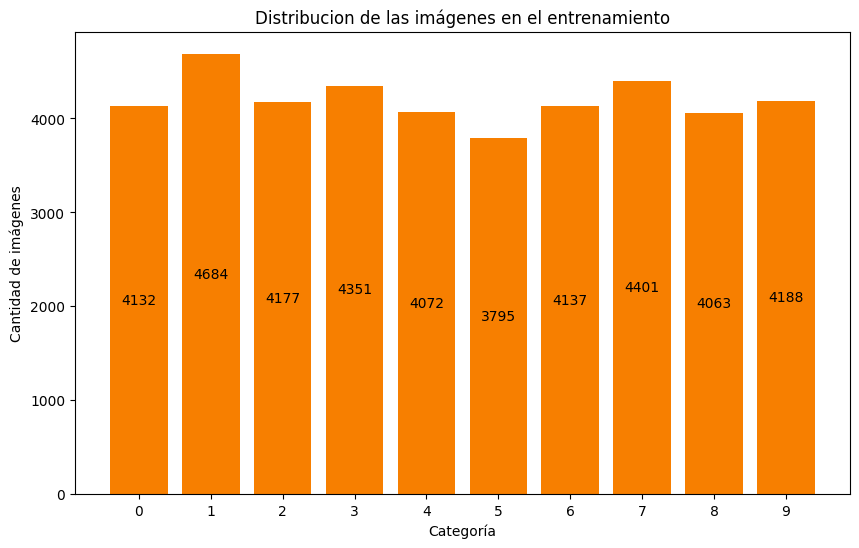

In [55]:
s = pd.Series(train_df['label'], dtype="category")
categories = np.array(s.cat.categories)
counts = np.array(s.value_counts(sort=False))
bar_labels = [str(i) for i in categories]
plt.bar_label(plt.bar(bar_labels, counts, color='#f77f00'), label_type='center')
plt.title('Distribucion de las imágenes en el entrenamiento')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de imágenes')
plt.bar(bar_labels, counts, label=bar_labels, color='#f77f00')


Se puede observar que las categorías no están balanceadas. La categoría 1 tiene más observaciones que las demás (`4684`). A continuación observamos un ejemplo de cada imágen:

In [157]:
samples = []
for i in range(10):
		sample = (train_df.loc[train_df['label'] == i])[:1]
		# Drop the label column
		sample = sample.drop(labels = ['label'],axis = 1)
		# Convert the dataframe to a numpy array
		# sample =[(v,v,v) for v in np.array(sample)]
		sample = np.array(sample)
		# Reshape the array into 28 x 28 array (2-dimensional array)
		sample = sample.reshape(28, 28)
		sample = sample.astype('uint8')
		samples.append(sample)

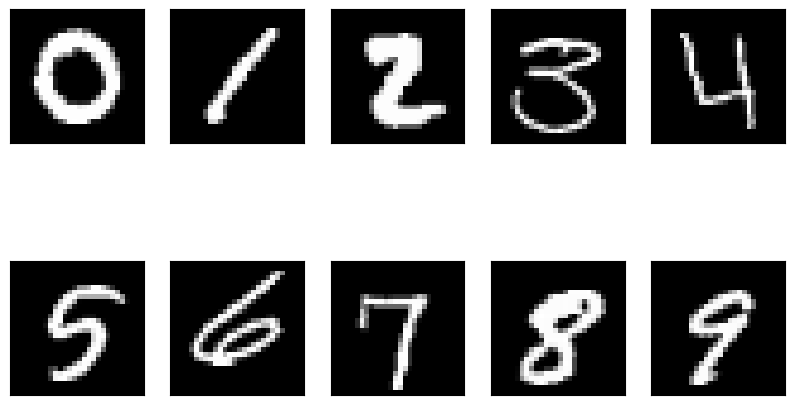

In [158]:
fig, ax = plt.subplots(2,5)
for axi in ax.flat:
		axi.xaxis.set_visible(False)
		axi.yaxis.set_visible(False)

for i in range(2):
	for j in range(5):
		image = samples[i*5+j]
		ax[i,j].imshow(image, cmap='gray')

# Utilizando Modelos 

In [177]:
y = train_df['label']
train_df = train_df.drop(['label'], axis=1)
X = train_df

### Red Neuronal Simple

In [178]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X, y)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1)